# Project for CS545

Sam Armstrong, Saloni Choudhary, Brandon Hua

In [1]:
import pandas as pd
import datetime
# univariate stacked lstm example
# from numpy import array
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

## Get Data


In [2]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [3]:
tickers = 'mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  29 of 29 downloaded


,Adj Close AAPL,Adj Close AXP,Adj Close BA,Adj Close CAT,Adj Close CSCO,Adj Close CVX,Adj Close DIS,Adj Close GE,Adj Close GS,Adj Close HD,...,Volume NKE,Volume PFE,Volume PG,Volume TRV,Volume UNH,Volume UTX,Volume V,Volume VZ,Volume WMT,Volume XOM
Date,,,,,,,,,,,,,,,,,,,,,


In [4]:
#data = data.drop([datetime.datetime(2016, 1, 18)])
data.shape

(1259, 174)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [5]:
MMM = data[['Adj Close MMM', 'Close MMM', 'High MMM', 'Low MMM', 'Open MMM', 'Volume MMM']]
MMM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

AAPL = data[['Adj Close AAPL', 'Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
AAPL.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
AXP = data[['Adj Close AXP', 'Close AXP', 'High AXP', 'Low AXP', 'Open AXP', 'Volume AXP']]
AXP.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
BA = data[['Adj Close BA', 'Close BA', 'High BA', 'Low BA', 'Open BA', 'Volume BA']]
BA.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CAT = data[['Adj Close CAT', 'Close CAT', 'High CAT', 'Low CAT', 'Open CAT', 'Volume CAT']]
CAT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CVX = data[['Adj Close CVX', 'Close CVX', 'High CVX', 'Low CVX', 'Open CVX', 'Volume CVX']]
CVX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CSCO = data[['Adj Close CSCO', 'Close CSCO', 'High CSCO', 'Low CSCO', 'Open CSCO', 'Volume CSCO']]
CSCO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
KO = data[['Adj Close KO', 'Close KO', 'High KO', 'Low KO', 'Open KO', 'Volume KO']]
KO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
DIS = data[['Adj Close DIS', 'Close DIS', 'High DIS', 'Low DIS', 'Open DIS', 'Volume DIS']]
DIS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
XOM = data[['Adj Close XOM', 'Close XOM', 'High XOM', 'Low XOM', 'Open XOM', 'Volume XOM']]
XOM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GE = data[['Adj Close GE', 'Close GE', 'High GE', 'Low GE', 'Open GE', 'Volume GE']]
GE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GS = data[['Adj Close GS', 'Close GS', 'High GS', 'Low GS', 'Open GS', 'Volume GS']]
GS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
HD = data[['Adj Close HD', 'Close HD', 'High HD', 'Low HD', 'Open HD', 'Volume HD']]
HD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
IBM = data[['Adj Close IBM', 'Close IBM', 'High AAPL', 'Low IBM', 'Open IBM', 'Volume IBM']]
IBM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
INTC = data[['Adj Close INTC', 'Close INTC', 'High INTC', 'Low INTC', 'Open INTC', 'Volume INTC']]
INTC.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JNJ = data[['Adj Close JNJ', 'Close JNJ', 'High JNJ', 'Low JNJ', 'Open JNJ', 'Volume JNJ']]
JNJ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JPM = data[['Adj Close JPM', 'Close JPM', 'High JPM', 'Low JPM', 'Open JPM', 'Volume JPM']]
JPM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MCD = data[['Adj Close MCD', 'Close MCD', 'High MCD', 'Low MCD', 'Open MCD', 'Volume MCD']]
MCD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MRK = data[['Adj Close MRK', 'Close MRK', 'High MRK', 'Low MRK', 'Open MRK', 'Volume MRK']]
MRK.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MSFT = data[['Adj Close MSFT', 'Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]
MSFT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
NKE = data[['Adj Close NKE', 'Close NKE', 'High NKE', 'Low NKE', 'Open NKE', 'Volume NKE']]
NKE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PFE = data[['Adj Close PFE', 'Close PFE', 'High PFE', 'Low PFE', 'Open PFE', 'Volume PFE']]
PFE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PG = data[['Adj Close PG', 'Close PG', 'High PG', 'Low PG', 'Open PG', 'Volume PG']]
PG.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
TRV = data[['Adj Close TRV', 'Close TRV', 'High TRV', 'Low TRV', 'Open TRV', 'Volume TRV']]
TRV.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UTX = data[['Adj Close UTX', 'Close UTX', 'High UTX', 'Low UTX', 'Open UTX', 'Volume UTX']]
UTX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UNH = data[['Adj Close UNH', 'Close UNH', 'High UNH', 'Low UNH', 'Open UNH', 'Volume UNH']]
UNH.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
VZ = data[['Adj Close VZ', 'Close VZ', 'High VZ', 'Low VZ', 'Open VZ', 'Volume VZ']]
VZ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
V = data[['Adj Close V', 'Close V', 'High V', 'Low V', 'Open V', 'Volume V']]
V.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
WMT = data[['Adj Close WMT', 'Close WMT', 'High WMT', 'Low WMT', 'Open WMT', 'Volume WMT']]
WMT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

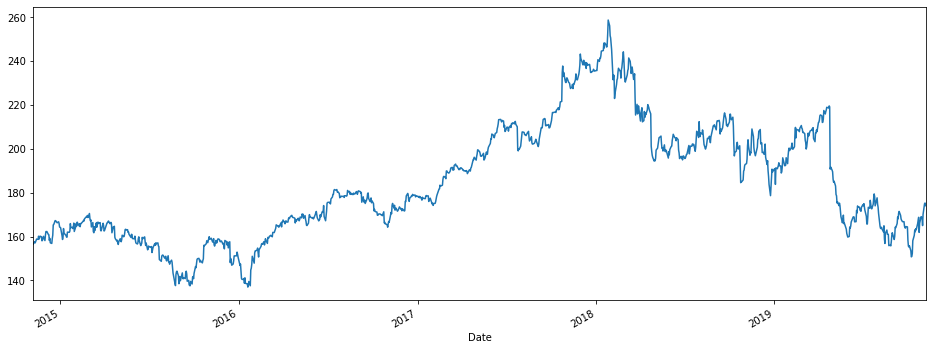

In [6]:
MMM['Close'].plot(figsize=(16,6))

# Setting up the data

In [7]:
def setup(look_back, data):
    train_percent = .8
    n_train = int(train_percent * len(data))
    train = data[:n_train]
    test = data[n_train - look_back:]
    return train, test
def partition_data(train_scaled, test_scaled, look_back):
    X_train = []
    y_train = []
    X_test = []
    for i in range(look_back, train_scaled.shape[0]):
        X_train.append(train_scaled[i-look_back:i, :])
        y_train.append(train_scaled[i, 1])
    for i in range(look_back, test_scaled.shape[0]):
        X_test.append(test_scaled[i-look_back:i, :])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
    return X_test, X_train, y_train

## Multivariate Model

In [8]:
look_back = 15
train, test = setup(look_back, MMM)

In [9]:
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.fit_transform(test)
#train_scaled, test_scaled = scale(train, test)

In [10]:
X_test, X_train, y_train = partition_data(train_scaled, test_scaled, look_back)

In [11]:
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 6)))

# Adding the output layer
regressor.add(Dense(units = 1))

In [12]:
# Compiling the RNN
regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 50)

Train on 992 samples
Epoch 1/10
992/992 [==============================] - 4s 4ms/sample - loss: 0.0409
Epoch 2/10
992/992 [==============================] - 0s 391us/sample - loss: 0.0044
Epoch 3/10
992/992 [==============================] - 0s 387us/sample - loss: 0.0018
Epoch 4/10
992/992 [==============================] - 0s 394us/sample - loss: 0.0013
Epoch 5/10
992/992 [==============================] - 0s 385us/sample - loss: 0.0012
Epoch 6/10
992/992 [==============================] - 0s 379us/sample - loss: 0.0011
Epoch 7/10
992/992 [==============================] - 0s 373us/sample - loss: 0.0011
Epoch 8/10
992/992 [==============================] - 0s 375us/sample - loss: 0.0010
Epoch 9/10
992/992 [==============================] - 0s 374us/sample - loss: 0.0010
Epoch 10/10
992/992 [==============================] - 0s 363us/sample - loss: 0.0010


In [13]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, 6, axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_test = test['Close'][look_back:]

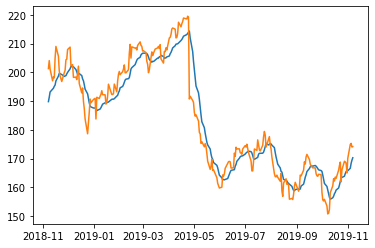

In [14]:
predicted_stock_price.index = Y_test.index
plt.plot(predicted_stock_price)
plt.plot(Y_test)
plt.show()

# Multivariate Regularization

The reason regularization exists is to limit the overfitting of data.

The purpose of regularizers is to add a penalty for weight size to the loss function
There are several regulizers we will try
* L1 - Sum of the absolute weights
* L2 - Sum of the squared weights
* L1_L2 - Both

Seeing as the testing data mean squared error is low and the predicted close price aligns with the actual close price pretty well, I assume the data to too overfitted if at all.

Adding a dropout is another way of regularization, but it didn't produce any better results.

Using Dropout regularization randomly drops that percentage of units in a layer when training data

## L1

In [15]:
look_back = 15
train, test = setup(look_back, MMM)

In [16]:
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.fit_transform(test)
#train_scaled, test_scaled = scale(train, test)

In [17]:
X_test, X_train, y_train = partition_data(train_scaled, test_scaled, look_back)

In [18]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 6), return_sequences = True,
                   kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.001), bias_regularizer=l1(0.01)))
#regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))


In [19]:
# Compiling the RNN
regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

Train on 992 samples
Epoch 1/15
992/992 [==============================] - 7s 7ms/sample - loss: 0.4879
Epoch 2/15
992/992 [==============================] - 1s 749us/sample - loss: 0.4114
Epoch 3/15
992/992 [==============================] - 1s 763us/sample - loss: 0.3732
Epoch 4/15
992/992 [==============================] - 1s 748us/sample - loss: 0.3415
Epoch 5/15
992/992 [==============================] - 1s 752us/sample - loss: 0.3138
Epoch 6/15
992/992 [==============================] - 1s 749us/sample - loss: 0.2916
Epoch 7/15
992/992 [==============================] - 1s 753us/sample - loss: 0.2726
Epoch 8/15
992/992 [==============================] - 1s 749us/sample - loss: 0.2571
Epoch 9/15
992/992 [==============================] - 1s 705us/sample - loss: 0.2439
Epoch 10/15
992/992 [==============================] - 1s 694us/sample - loss: 0.2328
Epoch 11/15
992/992 [==============================] - 1s 698us/sample - loss: 0.2228
Epoch 12/15
992/992 [=======================

In [20]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, 6, axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_test = test['Close'][look_back:]

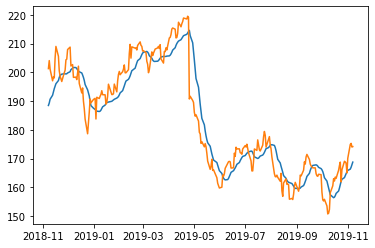

In [21]:
predicted_stock_price.index = Y_test.index
plt.plot(predicted_stock_price)
plt.plot(Y_test)
plt.show()

With this specific test, it seems as though our loss mean squared error isn't as good as without using regularizers. The point of using regularizers is to prevent overfitting of the data. As our test with no regularizers produced a low mean quared error and produced pretty good results, I don't think our data was very overfitted if it was

## L2

In [22]:
look_back = 15
train, test = setup(look_back, MMM)

In [23]:
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.fit_transform(test)
#train_scaled, test_scaled = scale(train, test)

In [24]:
X_test, X_train, y_train = partition_data(train_scaled, test_scaled, look_back)

In [25]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 6), 
                   kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
#regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))


In [26]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 15, batch_size = 100)

Train on 992 samples
Epoch 1/15
992/992 [==============================] - 3s 4ms/sample - loss: 0.0684
Epoch 2/15
992/992 [==============================] - 0s 205us/sample - loss: 0.0605
Epoch 3/15
992/992 [==============================] - 0s 207us/sample - loss: 0.0568
Epoch 4/15
992/992 [==============================] - 0s 202us/sample - loss: 0.0538
Epoch 5/15
992/992 [==============================] - 0s 201us/sample - loss: 0.0510
Epoch 6/15
992/992 [==============================] - 0s 200us/sample - loss: 0.0485
Epoch 7/15
992/992 [==============================] - 0s 196us/sample - loss: 0.0462
Epoch 8/15
992/992 [==============================] - 0s 202us/sample - loss: 0.0440
Epoch 9/15
992/992 [==============================] - 0s 202us/sample - loss: 0.0421
Epoch 10/15
992/992 [==============================] - 0s 203us/sample - loss: 0.0402
Epoch 11/15
992/992 [==============================] - 0s 204us/sample - loss: 0.0385
Epoch 12/15
992/992 [=======================

In [27]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, 6, axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_test = test['Close'][look_back:]

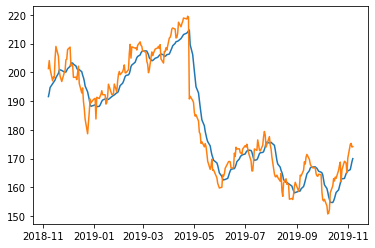

In [28]:
predicted_stock_price.index = Y_test.index
plt.plot(predicted_stock_price)
plt.plot(Y_test)
plt.show()

This matched the results we acheived without using any regularizers

## L1 & L2

In [29]:
look_back = 15
train, test = setup(look_back, MMM)

In [30]:
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.fit_transform(test)
#train_scaled, test_scaled = scale(train, test)

In [31]:
X_test, X_train, y_train = partition_data(train_scaled, test_scaled, look_back)

In [32]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 6), 
                   kernel_regularizer=l1_l2(l1=0.0001, l2=0.001), recurrent_regularizer=l1_l2(l1=0.0001, l2=0.001), 
                   bias_regularizer=l1_l2(l1=0.0001, l2=0.001)))

# Adding the output layer
regressor.add(Dense(units = 1))

In [33]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 15, batch_size = 75)

Train on 992 samples
Epoch 1/15
992/992 [==============================] - 4s 4ms/sample - loss: 0.1102
Epoch 2/15
992/992 [==============================] - 0s 277us/sample - loss: 0.0874
Epoch 3/15
992/992 [==============================] - 0s 280us/sample - loss: 0.0786
Epoch 4/15
992/992 [==============================] - 0s 282us/sample - loss: 0.0720
Epoch 5/15
992/992 [==============================] - 0s 280us/sample - loss: 0.0665
Epoch 6/15
992/992 [==============================] - 0s 278us/sample - loss: 0.0616
Epoch 7/15
992/992 [==============================] - 0s 288us/sample - loss: 0.0572
Epoch 8/15
992/992 [==============================] - 0s 279us/sample - loss: 0.0533
Epoch 9/15
992/992 [==============================] - 0s 280us/sample - loss: 0.0498
Epoch 10/15
992/992 [==============================] - 0s 280us/sample - loss: 0.0467
Epoch 11/15
992/992 [==============================] - 0s 280us/sample - loss: 0.0439
Epoch 12/15
992/992 [=======================

In [34]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, 6, axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_test = test['Close'][look_back:]

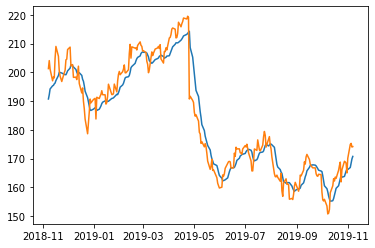

In [35]:
predicted_stock_price.index = Y_test.index
plt.plot(predicted_stock_price)
plt.plot(Y_test)
plt.show()